In [1]:
import matplotlib.pyplot as plt
from IPython.display import Audio
from data import BirdClefTrainAudio
import librosa
import pandas as pd
import numpy as np
import mir_eval.sonify
import time

In [2]:
start = time.time()

In [3]:
sr=16000

In [4]:
data_folder = "data"
ds = BirdClefTrainAudio(data_folder, max_duration=5, sr=sr)

In [5]:
taxonomy = pd.read_csv(f"{data_folder}/taxonomy.csv", index_col="primary_label")

In [6]:
i = 0
y, label = ds[i]

In [7]:
print(f"Loaded: {time.time()-start} seconds since start")

Loaded: 1.3586981296539307 seconds since start


In [8]:
Audio(data=y, rate=sr)

In [9]:
taxonomy.iloc[label]

inat_taxon_id                   1139490
scientific_name    Ragoniella pulchella
common_name        Ragoniella pulchella
class_name                      Insecta
Name: 1139490, dtype: object

In [10]:
stft = librosa.stft(y)

In [11]:
print(f"STFT: {time.time()-start} seconds since start")

STFT: 1.8721091747283936 seconds since start


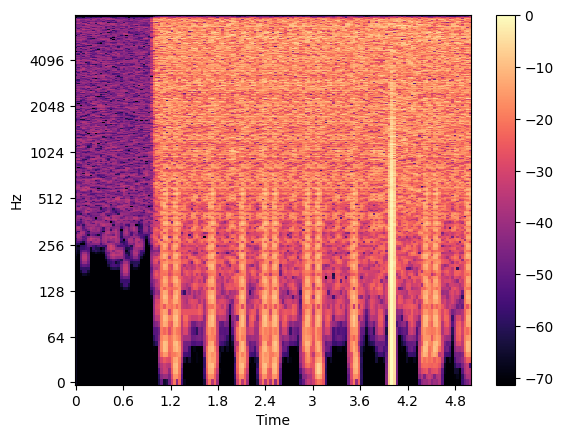

In [12]:
mag, phase = librosa.magphase(stft)

# Plot the spectrum
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max),
                               y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax);

In [21]:
f0, voicing, voicing_probability = librosa.pyin(y=y, sr=sr, fmin=50, fmax=4000)

In [22]:
print(f"F0: {time.time()-start} seconds since start")

F0: 16.684709787368774 seconds since start


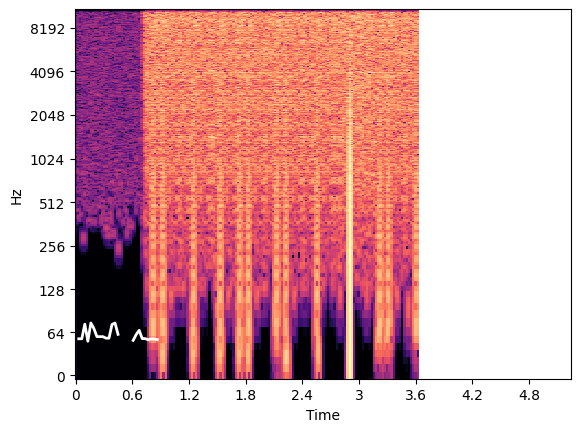

In [23]:
S = np.abs(librosa.stft(y))

times = librosa.times_like(S, sr=sr)

fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, f0, linewidth=2, color='white', label='f0')
#ax.legend()

In [16]:
f0

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [17]:
S = np.abs(librosa.stft(y))
# Let's use the first 30 harmonics: 1, 2, 3, ..., 30
harmonics = np.arange(1, 10)

# And standard Fourier transform frequencies
frequencies = librosa.fft_frequencies(sr=sr)

harmonic_energy = librosa.f0_harmonics(S, f0=f0, harmonics=harmonics, freqs=frequencies)

In [18]:
print(f"Harmonics: {time.time()-start} seconds since start")

Harmonics: 3.4374821186065674 seconds since start


[Text(0, 0.5, 'Harmonics')]

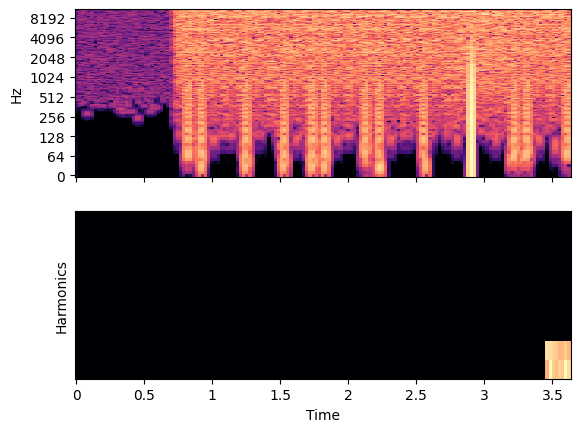

In [19]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=2, sharex=True)

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[0])
librosa.display.specshow(librosa.amplitude_to_db(harmonic_energy, ref=np.max),
                         x_axis='time', ax=ax[1])
ax[0].label_outer()
ax[1].set(ylabel='Harmonics')

In [20]:
# f0 takes value np.nan for unvoiced regions, but this isn't
# helpful for synthesis.  We'll use `np.nan_to_num` to replace
# nans with a frequency of 0.
f0_synth = np.nan_to_num(f0)

y_out = np.zeros_like(y)

for i, (factor, energy) in enumerate(zip(harmonics, harmonic_energy)):
    # Mix in a synthesized pitch contour
    y_out = y_out + mir_eval.sonify.pitch_contour(times, f0_synth * factor,
                                                amplitudes=energy,
                                                fs=sr,
                                                length=len(y))

Audio(data=y_out, rate=sr)